In [1]:
# Clear workspace
rm(list = ls())
# Load libraries
library(tidyverse)
library(RColorBrewer)
library(igraph)
library(igraphdata)
library(corrplot)
# setup things
theme_set(theme_light())
my_palette <- colorRampPalette(brewer.pal(n = 9, name = "PuBuGn"))(51)[2:51] # remove white
igraph_options(vertex.color = "aquamarine3", vertex.frame.color = "white", vertex.frame.size = 1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

corrplot 0.84 loaded


# Networks: A very brief Introduction

What we have seen yesterday:

1. Fundamentals of Graph Theory
2. How to 
    * build `igraph` graph objects,
    * plot them with some customisation
    * get their characterising matrices - adjacency matrix $A$, and (normalised) Laplacian **L**
    * compute the degree of each vertex, the degree distribution and to plot the latter
    * generate synthetic networks (ER, Barabasi-Albert)

## Network Models

### 1. Random graph model

The simplest network model is the random graph due to Erdos and Renyi, [Erdos and Renyi (1959)](http://www.leonidzhukov.net/hse/2016/networks/papers/erdos-1959-11.pdf) and it is often indicated by their names.

In the Erdos-Renyi model (ER) some parameters have fixed values while the network is otherwise random.
Fixing the number $N$ of vertices and $m$ of edges and placing the edges randomly one gets $G(N, m)$.
Typically, no self- or multi-deges are allowed, i.e. $G(N, m)$ is a simple graph.

The rigorous definition is the following
> **ER Random Graph**
  Consider the ensemble $\Omega$ of all possible graphs with $N$ labelled vertices $v_1, \dots, v_N$ and $m$ edges.
  A random graph $G(N, m)$ is an element of $\Omega$ selected with uniform probability $P(G) = \frac{1}{|\Omega|}$.

$|\Omega|$ is derived by simple combinatorics:

* for a graph $G=(V, E)$ having $m$ edges means that $|E|=m$, 
* $E \subseteq V \times V$ and $|V \times V|=\binom{N}{2}=\frac{N(N-1)}{2}$.

The size of $\Omega$ is then the number of subsets of size $m$ of a set of size $\binom{N}{2}$, that is $\binom{\binom{N}{2}}{m}$.

In [2]:
N <- 100
N*(N-1)/2

[1] 4950

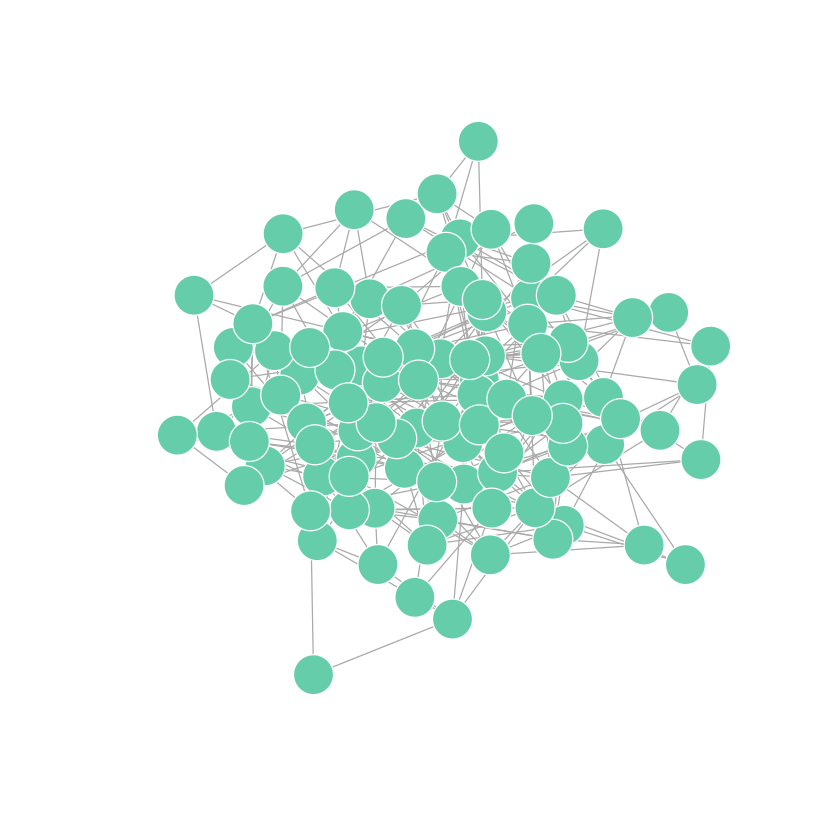

In [3]:
m <- 345
g <- sample_gnm(n = N, m = m)
plot(g, vertex.label = NA)

## Network Properties

If a graph is connected the geodesic or shortest-path distance $d_{i, j} = d_{sp}(v_i, v_j)$ is the length of a shortest path connecting $v_i$ and $v_j$.

The shortest-path distance matrix $D_{sp}$ can be computed using `igraph::distances`

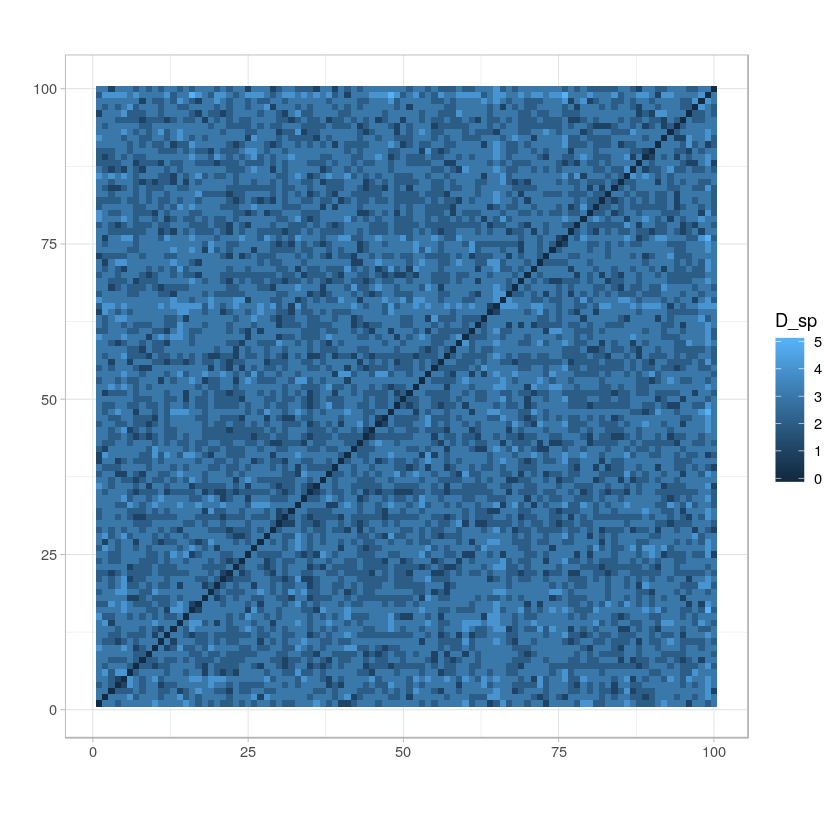

In [4]:
D_sp <- distances(graph = g)
colnames(D_sp) <- 1:N
as_tibble(D_sp) %>% 
  add_column("node" = 1:N, .before = 1) %>%
  gather(key, value, -node) %>%
  mutate(key = as.integer(key)) %>%
  ggplot(aes(x = node, y = key, fill = value)) +
    geom_tile() +
    coord_equal() +
    labs(x = "", y = "", fill = "D_sp")

The **diameter** of a graph is the length of the longest geodesic (shortest-path), i.e. $diam(G) = \max_{i, j} d_{ij}$.

In [5]:
diameter(g)

[1] 5

In [6]:
get.diameter(g)

+ 6/100 vertices, from f58a100:
[1] 16 12 10 85 91 99

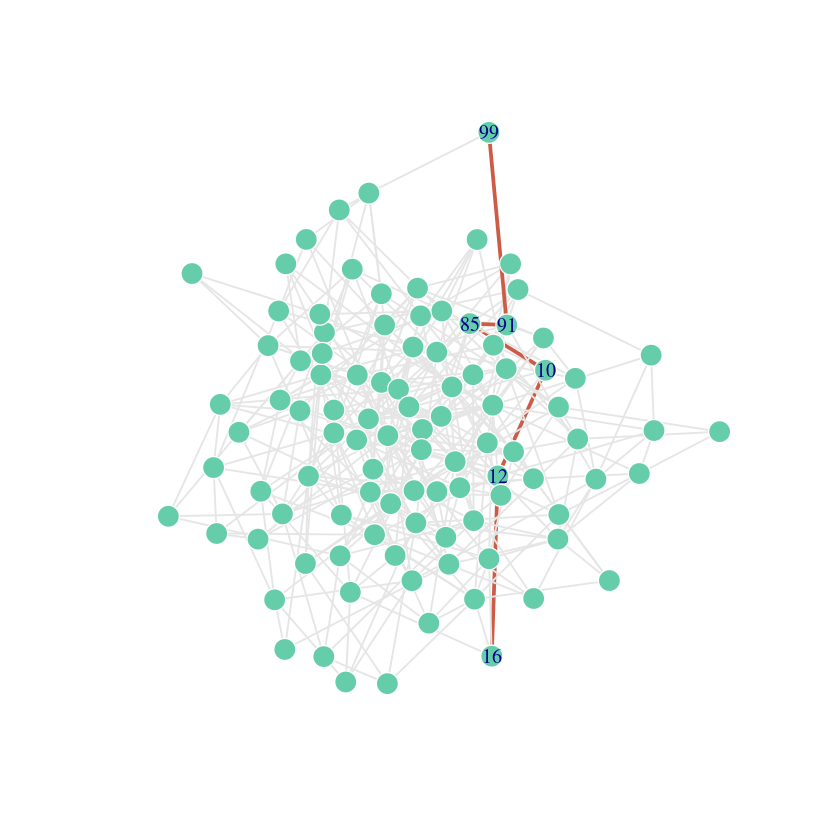

In [7]:
V(g)$label <- V(g)
V(g)$label[!(V(g) %in% get.diameter(g))] <- NA
E(g)$color <- "#e5e5e5"
E(g, path = get.diameter(g))$color <- "coral3"
E(g)$width <- 1.5
E(g, path = get.diameter(g))$width <- 3
plot(g, vertex.size = 8)

#### Average shortest-path

We can compute the averege geodesic length as $$\langle l \rangle = \frac{1}{N(N-1)} \sum_{i\neq j} d_{ij}.$$

The **small-world effect** refers to the fact that in many real networks the typical geodesic distance is surprisingly short, in particular when compared with the number of nodes of the network.

See Milgram's small-world experiment (1967) and six degree of separation.

In [8]:
sum(D_sp)/N/(N-1)

[1] 2.566263

Average degree $$\langle k \rangle = \frac{1}{N} \sum_i k_i = \sum_k k p_k = \frac{2|E|}{|V|} = \frac{2m}{N}$$

In [9]:
avg_k <- 2*m/N
avg_k

[1] 6.9

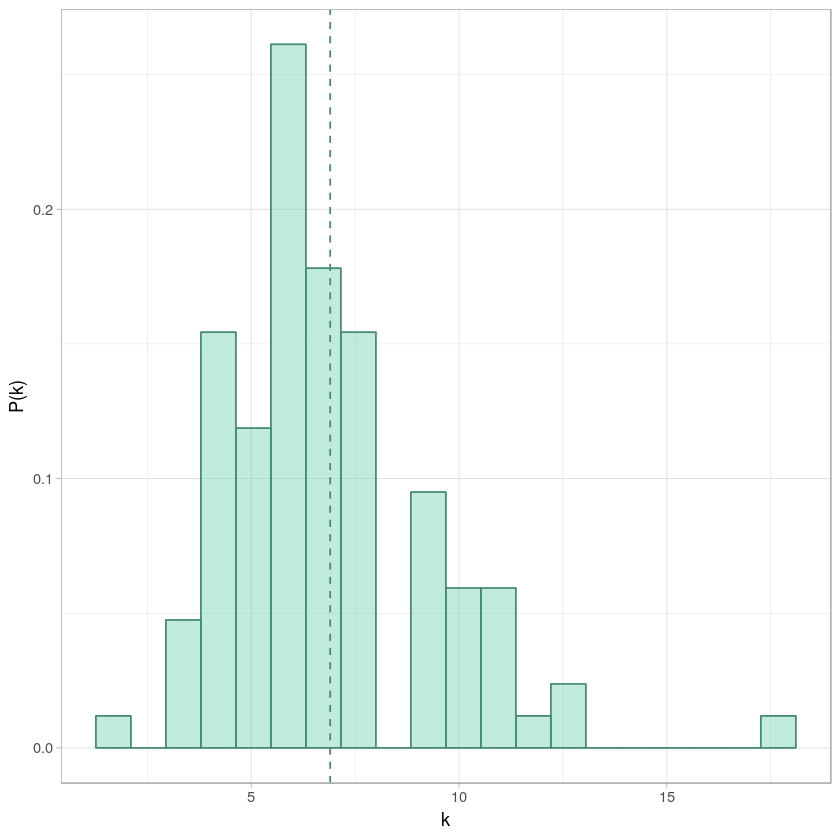

In [10]:
ggplot(data.frame("k" = degree(g)), aes(k)) +
  geom_histogram(aes(y = ..density..), bins = 20, color = "aquamarine4", fill = "aquamarine3", alpha = .4) +
  geom_vline(aes(xintercept = mean(k)), color = "aquamarine4", linetype = "dashed") +
  labs(x = "k", y = "P(k)")

### Gilbert Random Graph

Given $N$ nodes each edge has the same probability $p$ of being included in the graph, independently from the others.

Let $\{G(N, p)\}$ be the ensemble of graphs with $N$ vertices, connection probability 
$$p = P\left(\{i, j\} \in E\right) \quad \forall i, j, \in 1, \dots, N$$ then a particular graph $G$ is selected with probability
\begin{equation}
P(G) = p^m (1-p)^{\binom{N}{2} - m}.
\end{equation}
where $m$ is the number of edges. 

Observe that if $p=0.5$ previous equation becomes
\begin{equation}
P(G) = p^m (1-p)^{\binom{N}{2} - m} = p^{\binom{N}{2}}
\end{equation}
and all graphs with $N$ nodes can be chosen with the same probability.

#### Distribution of edges in the model

The number of graphs with exactly $N$ nodes and $m$ vertices:

1. $\binom{N}{2}$ number of pairs of vertices
2. how many ways to choose $m$ elements (edges) from a set of $\binom{N}{2}$ elements $\longrightarrow$ combinations! $\binom{\binom{N}{2}}{m}$

Then the probability of drawing from the ensemble $\{G(N, p)\}$ a graph with $m$ edges is
$$P(m) = \binom{\binom{N}{2}}{m} P(G) = \binom{\binom{N}{2}}{m} p^m (1-p)^{\binom{N}{2} - m}.$$

$G(N, p)$ is also called "Bernoulli random graph" for this reason.

#### Average Degree

We saw that $\langle k \rangle = \frac{2m}{N}$. Thus, in case of $G(N, m)$ we have
$$
\begin{aligned}
\langle k \rangle & = \sum_{m = 0}^{\binom{N}{2}} \frac{2m}{N} P(m) \\
& = \frac{2}{N} \sum_{m = 0}^{\binom{N}{2}} m P(m) \\
& = \frac{2}{N} \langle m \rangle = (N-1) p.
\end{aligned}
$$

#### Degree distribution

* The probability of vertex $i$ having exactly degree $k$ is $p^k (1-p)^{N-1-k}$ 
* there are $\binom{N-1}{k}$ possible ways to select the $k$ nodes $i$ is linked to, hence

$$P(k) = \binom{N-1}{k} p^k (1-p)^{N-1-k}$$

#### Poisson approximation

For large networks the expected degree is approximately constant $c = (N-1)p$ and so in the limit for $N \to \infty$ $p = \frac{c}{N-1} \to 0$. We know from probability theory that the binomial distribution can be approximated with a Poisson with parameter $c$. $G(N, p)$ is also called Poisson random graph for this reason.

### 2. Scale-free model

Network with a power-law degree distribution
$$P(k) \propto k^{-\alpha}$$
are called scale-free.

Observe that the first moment (expected degree) exists only if $1 < \alpha$. Typically in empirical networks $2 \leq \alpha \leq 3$.

#### The Barabasi-Albert model: Growth and preferential attachment

* GROWTH: in real networks the number of nodes continually grows thanks to the addition of new nodes
* most real networks new nodes prefer to link to the more connected nodes, a process called preferential attachment

#### Reference Papers

[BARABÁSI, A.-L., & BONABEAU, E. (2003). Scale-Free Networks. Scientific American. Scientific American, a division of Nature America, Inc.](https://doi.org/10.2307/26060284)

[Clauset, A., Shalizi, C. R., & Newman, M. E. J. (2009). Power-Law Distributions in Empirical Data. SIAM Review, 51(4), 661–703.](https://doi.org/10.1137/070710111)

[Broido, A. D., & Clauset, A. (2018). Scale-free networks are rare.](http://arxiv.org/abs/1801.03400)

[Barabasi, Network Science - Ch. 5](http://barabasi.com/f/622.pdf)

#### Other network models
* Small-world model
* _Generative network models_, they model the mechanisms by which networks are created.

See Chapter 14 of _Newman - Networks: An Introduction_, for further reference.

## Centrality measures

* Fundamental concept in network analysis: _which is the most important node?_
* First developments by social scientists Bavelas (1948, 1950), Leavitt (1951), Bonacich (1972)
* Definition of _importance_?
* [In 1978 Freeman](https://goo.gl/8j4z9Y), a mathematical social scientist, categorises existing centrality measures in three groups, whose more representative measures are 
    * degree,
    * closeness,
    * betweenness.
* [Borgatti, S. P., & Everett, M. G. (2006). A graph-theoretic perspective on centrality. Social networks, 28(4), 466-484.](https://doi.org/10.1016/j.socnet.2005.11.005).

In the next section we are going to see the definitions of common centralities, how to compute them using `igraph` and we will compare them on toy models.

### 2.1 Cenrality Measures

#### Degree

$k_i$, the degree of vertex $i$, can be seen as a measure of its importance inside the network, indeed $i$ receives a centrality point for each and everyone of its neighbours; the more connections, the highest $i$'s centrality.

In case of directed networks one has to distinguish between \textit{in-} and \textit{out-degree}.
For instance, a scientific paper is evaluated by the number of citations it receives, i.e. its out-degree in the citation network.

In [11]:
data(UKfaculty)
UKfaculty

IGRAPH 6f42903 D-W- 81 817 -- 
+ attr: Type (g/c), Date (g/c), Citation (g/c), Author (g/c), Group
| (v/n), weight (e/n)
+ edges from 6f42903:
 [1] 57->52 76->42 12->69 43->34 28->47 58->51  7->29 40->71  5->37 48->55
[11]  6->58 21-> 8 28->69 43->21 67->58 65->42  5->67 52->75 37->64  4->36
[21] 12->49 19->46 37-> 9 74->36 62-> 1 15-> 2 72->49 46->62  2->29 40->12
[31] 22->29 71->69  4-> 3 37->69  5-> 6 77->13 23->49 52->35 20->14 62->70
[41] 34->35 76->72  7->42 37->42 51->80 38->45 62->64 36->53 62->77 17->61
[51]  7->68 46->29 44->53 18->58 12->16 72->42 52->32 58->21 38->17 15->51
[61] 22-> 7 22->69  5->13 29-> 2 77->12 37->35 18->46 10->71 22->47 20->19
+ ... omitted several edges

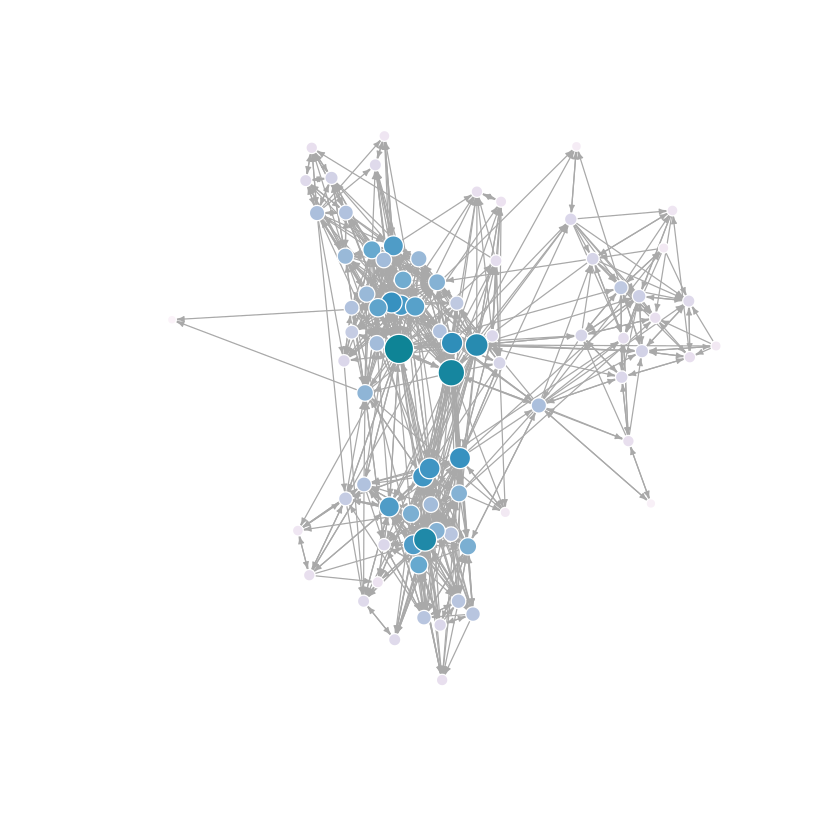

In [12]:
degC <- degree(UKfaculty, normalized = T)
uk_lay <- layout_nicely(UKfaculty)
plot(UKfaculty, layout = layout_nicely, vertex.label = NA,vertex.size = 3 + 10*degC,
     vertex.color = my_palette[as.factor(degC)], edge.arrow.size = 0.3)

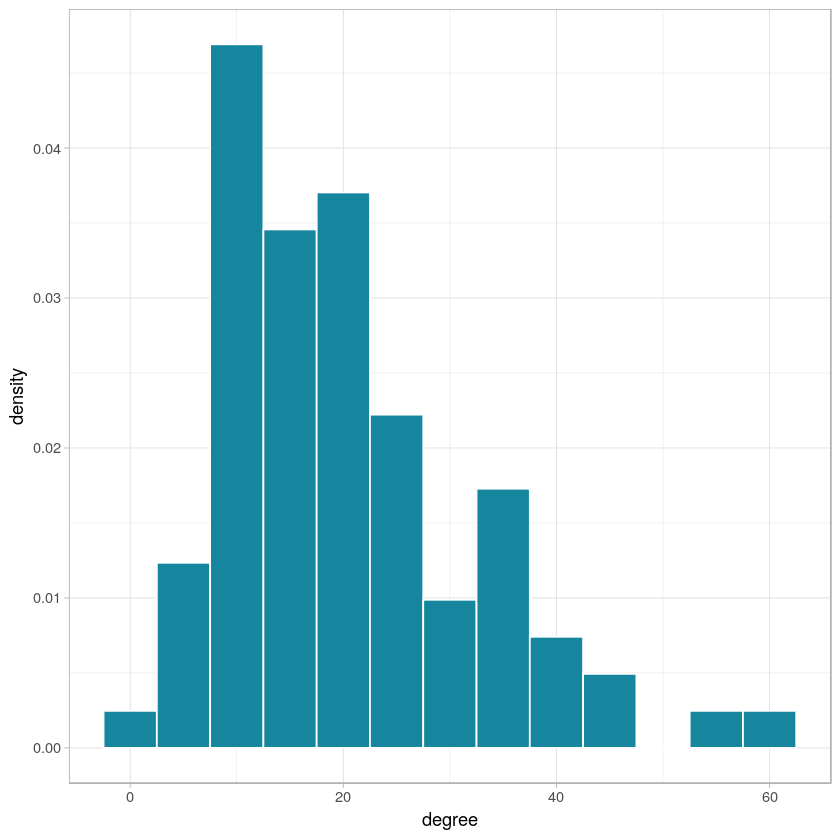

In [13]:
ggplot(data.frame(degree = degree(UKfaculty)), aes(degree)) + 
  geom_histogram(aes(y = ..density..), binwidth = 5, fill = my_palette[35], color = "white")

#### Closeness 
The measures seen until now are all based on the degree and the degree of a vertex is viewed as important as an index of its potential communication activity.

The closeness is based a different intuitive conception of centrality, that is the degree to which a point is _close to_ all other points in the graph.
In order to say what "close" means, a definition of distance is needed and the natural choice is the shortest path distance.

Mathematically, closeness centrality measures the mean geodesic distance from a point to other vertices.
Given $D = \{d_{ij}\}$ the shortest path distance matrix, the mean distance $l_i$ is
\begin{equation*}
  l_i = \frac1N \sum_{j} d_{ij}.
\end{equation*}
This is a measure of \textit{outlyingness} since it takes a low value when the terms $d_{ij}$ are small, i.e. $i$ is separated from other vertices by short geodesics.
Hence, the closeness centrality of vertex $i$ is defined as
\begin{equation}
  C_i = \frac{1}{l_i} = \frac{N}{\sum_{j} d_{ij}} \label{eq:cloC}
\end{equation}

In [14]:
summary(closeness(UKfaculty))
cloC <- closeness(UKfaculty, normalized = T)

Warning message in closeness(UKfaculty):
“At centrality.c:2617 :closeness centrality is not well-defined for disconnected graphs”

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001543 0.0019763 0.0025575 0.0025473 0.0030120 0.0046512 

Warning message in closeness(UKfaculty, normalized = T):
“At centrality.c:2617 :closeness centrality is not well-defined for disconnected graphs”

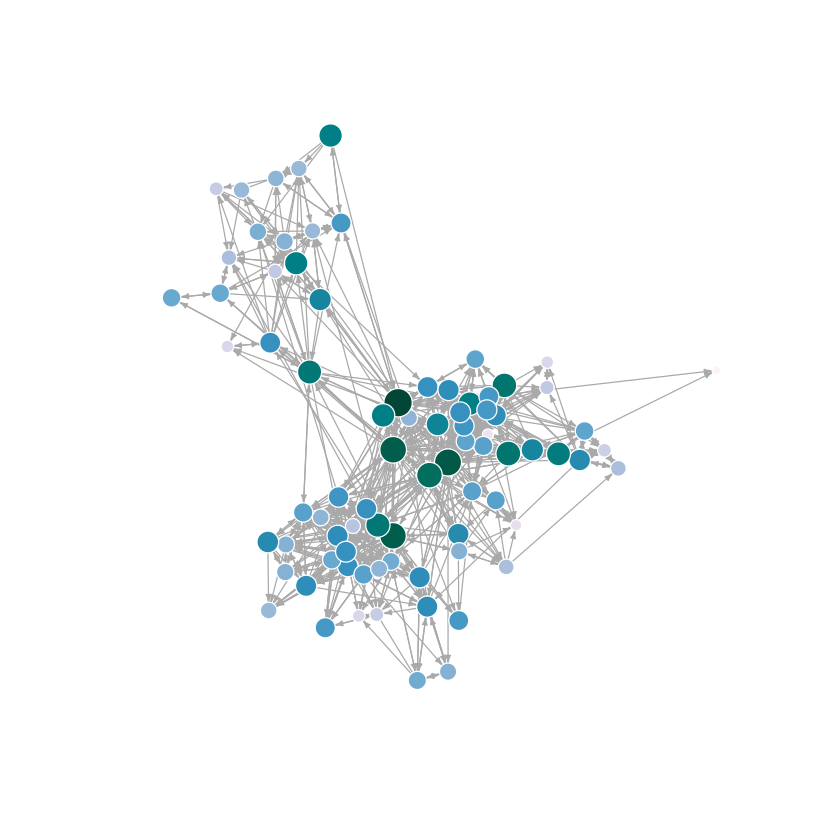

In [15]:
plot(UKfaculty, layout = layout_nicely, vertex.label = NA, vertex.size = 3 + 20*cloC,
     vertex.color = my_palette[cut(as.numeric(cloC), breaks = 50)], edge.arrow.size = 0.3)

#### Betweenness Centrality
A third view of node centrality is based upon the frequency with which a point falls between pairs of other nodes on the shortest paths connecting them.
Again the idea comes from social sciences, where a person strategically located on the communication paths linking pairs of others is central, since she/he can influence the group controlling the information flow [Freeman (1978)](https://doi.org/10.1016/0378-8733(78)90021-7).

Newman explains the concept very clearly

>  Suppose we have a network with something flowing around it. [...] Let us initially make the assumption that every connected pair of vertices in the network exchanges a message with equal probability per unit time and that massages always take the shortest path (or one such paths, if more exist). [...] After a suitably long time, how many massages, on average, will have passed through each vertex en route to their destination? - Newman (2010)

The rate at which messages flow through geodesic paths is constant, so the number of messages passing trough each vertex is proportional to the number of geodesics the vertex lies on, that is its betweenness centrality.

Let $i, s, t \in V$, $n_{st}(i) = 1$ if $i$ lies on the shortest path between $s$ and $t$.
Then
\begin{equation}
  x_i = \sum_{s, t} n_{st} (i). 
\end{equation}
Observe that in an undirected network the geodesic path from $s$ to $t$ is the same as the one $t \to s$, so the centrality $x_i$ is essentially counting the paths twice.
Usually one is interested only in the relative magnitude of the centralities, so it is not mandatory to divide $x_i$ by two.

Further one has also to define $n_{st}(s)$ and $n_{st}(t)$, whether $s$ and $t$ lie on the path between $s$ and $t$.
Excluding them ($n_{st}(s)=0$) only reduces the betweenness value by twice the size of the component to which the vertex belongs, so the ranking inside the component remains unchanged.

The rankings of nodes in different components may change, though it is rarely a problem, as betweenness is usually not used to compare vertices in different components - intuitively, those vertices compete for different areas of influence.

Finally, in case of more than one shortest path connecting nodes $s$ and $t$, a small correction has to be introduced
\begin{equation}
  x_i = \sum_{s, t} \frac{n_{st} (i)}{g_{st}(i)}
\end{equation}
where $g_{st}(i)$ is the total number of geodesic paths from $s$ to $t$.

In [16]:
summary(betweenness(UKfaculty))
btwC <- betweenness(UKfaculty, normalized = T)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    7.333   90.248  177.287  260.070 1223.084 

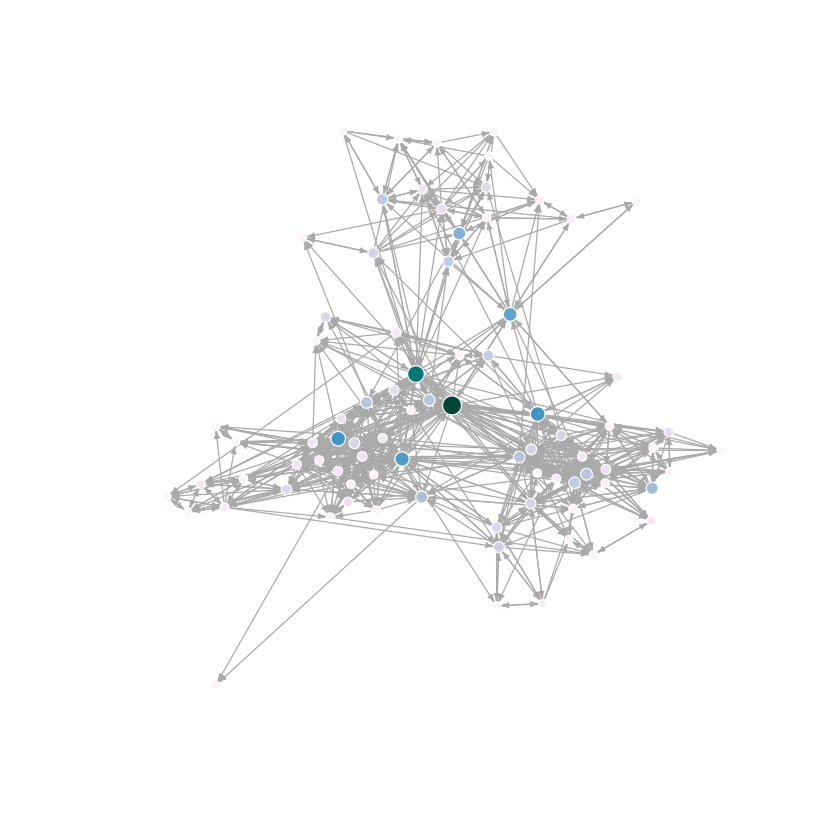

In [17]:
plot(UKfaculty, layout = layout_nicely, vertex.label = NA, vertex.size = 3 + 20*btwC,
     vertex.color = my_palette[cut(as.numeric(btwC), breaks = 50)], edge.arrow.size = 0.3)

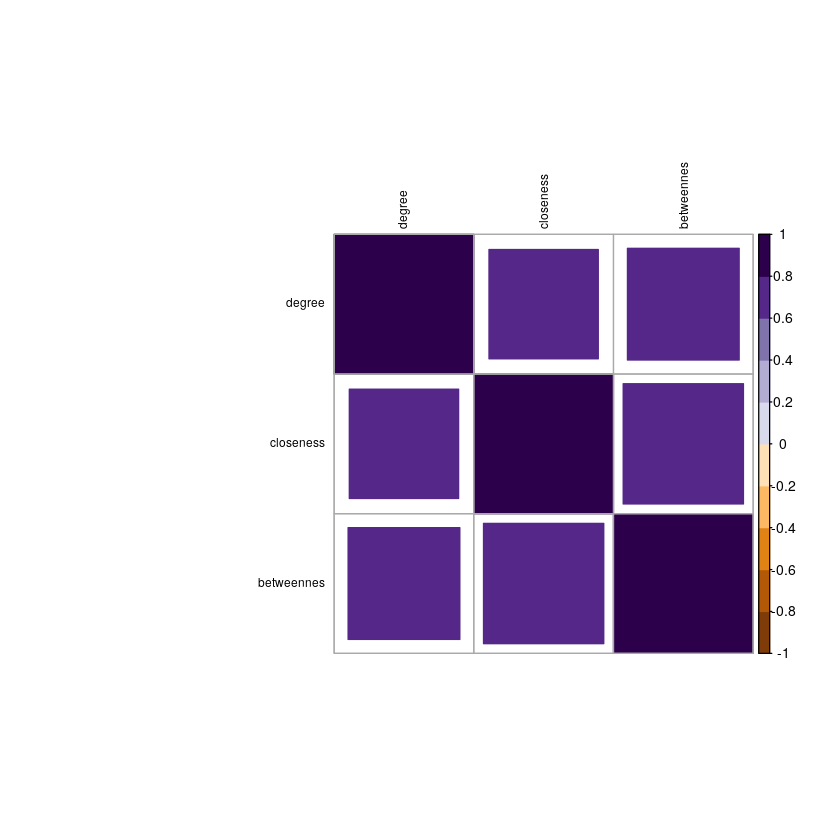

In [18]:
cor_dd <- list("degree" = degC, "closeness" = cloC, "betweennes" = btwC)
cor_dd <- cor(as.data.frame(cor_dd), method = "spearman")
corrplot(cor_dd, method = "square",
         outline = F, addgrid.col = "darkgray", order = "hclust",
         mar = c(3, 3, 3, 1),
         tl.col = "black", tl.cex = .6, cl.cex = .7,
         col = brewer.pal(n = 10, name = "PuOr"))

## References

[Borgatti, S. P., & Everett, M. G. (2006). A Graph-theoretic perspective on centrality. Social Networks, 28(4), 466–484.](https://doi.org/10.1016/J.SOCNET.2005.11.005)

## 3. Community detection

What is a community, how can we define a group?

### Walktrap Community

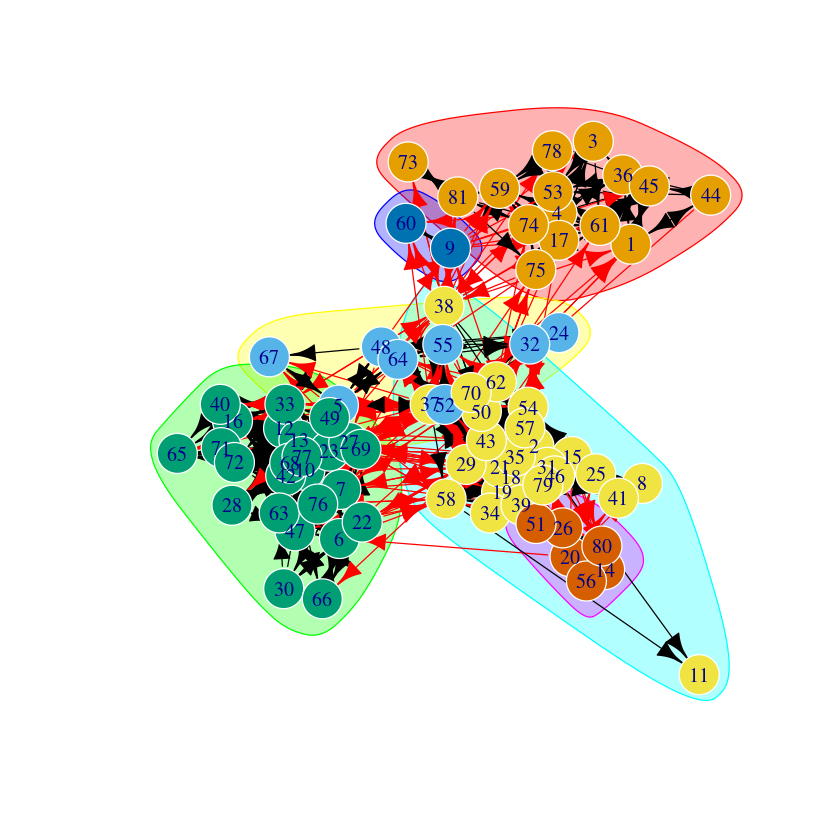

In [19]:
walk <- cluster_walktrap(UKfaculty)
plot(walk, UKfaculty)

Colors of the edges: by default the edges **within communities** are colored **black** and other edges are red.

In [20]:
modularity(walk)

[1] 0.5578907

### Optimisation of Modularity

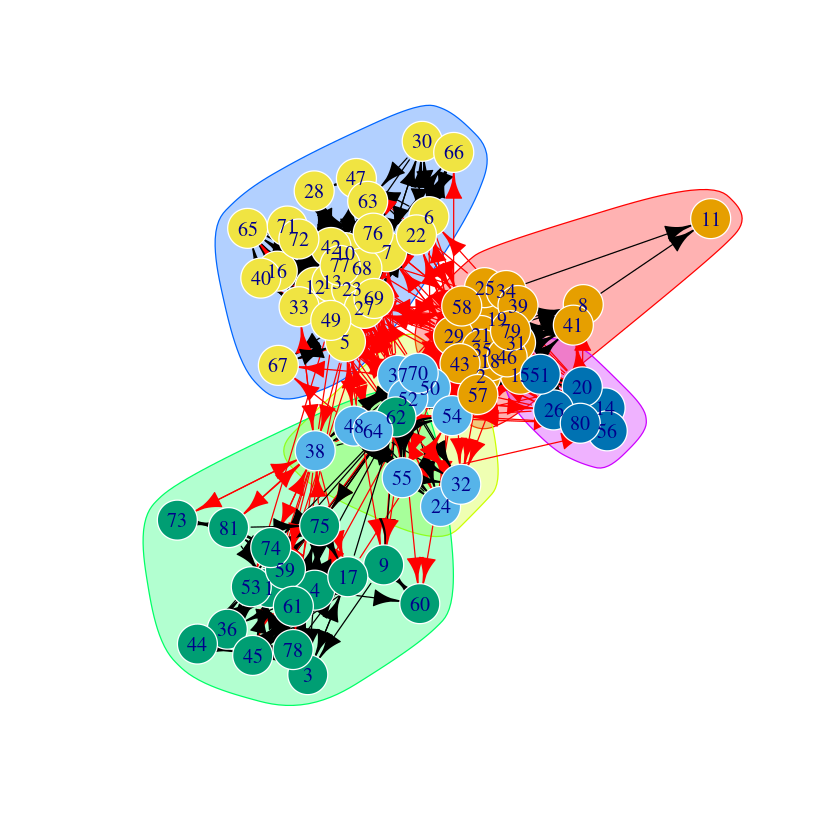

In [21]:
fgc <- cluster_fast_greedy(as.undirected(UKfaculty))
plot(fgc, UKfaculty)

In [22]:
modularity(fgc)

[1] 0.5622017

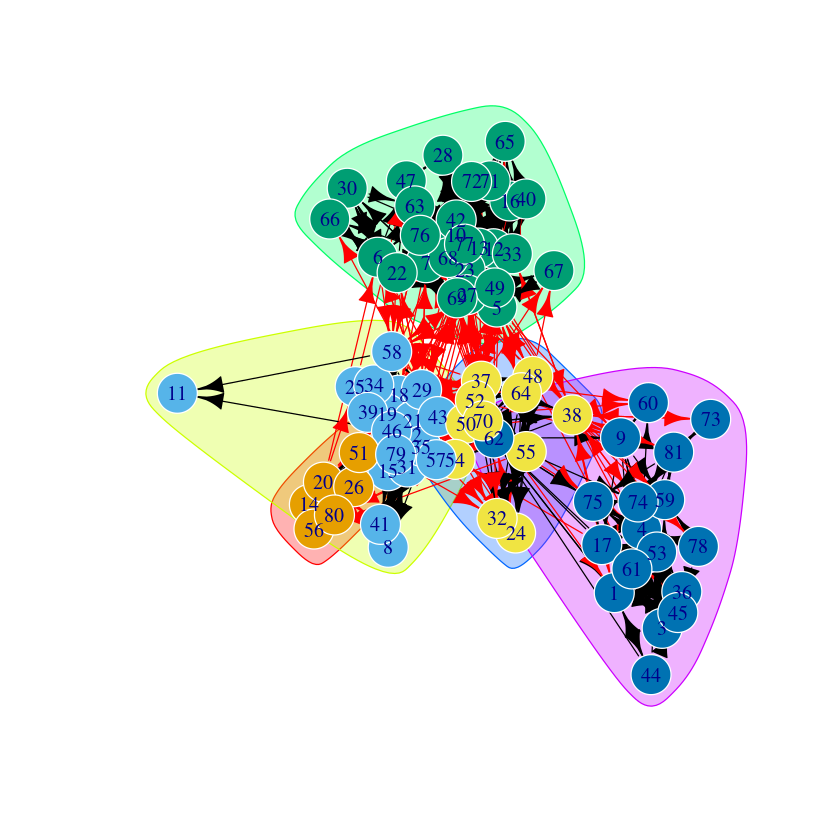

In [23]:
cll <- cluster_louvain(as.undirected(UKfaculty))
plot(cll, UKfaculty)

In [24]:
modularity(cll)

[1] 0.5622017